In [1]:
import awkward as ak

In [2]:
from coffea.nanoevents import NanoAODSchema, NanoEventsFactory

In [3]:
events = NanoEventsFactory.from_root(
    "/commonfs/store/mc/RunIISummer20UL18NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/120000/0520A050-AF68-EF43-AA5B-5AA77C74ED73.root",
    schemaclass=NanoAODSchema,
    metadata={'dataset':'TTToSemiLeptonic_18'}
).events()

In [4]:
events.MET.fields

['MetUnclustEnUpDeltaX',
 'MetUnclustEnUpDeltaY',
 'covXX',
 'covXY',
 'covYY',
 'phi',
 'pt',
 'significance',
 'sumEt',
 'sumPtUnclustered',
 'fiducialGenPhi',
 'fiducialGenPt']

In [5]:
events.PV.fields

['ndof', 'x', 'y', 'z', 'chi2', 'score', 'npvs', 'npvsGood']

In [6]:
events.PV.npvs

<Array [26, 12, 15, 8, 35, ... 15, 48, 28, 34] type='1294000 * int32[parameters=...'>

In [7]:
from coffea import util
from coffea.processor import accumulate
from monoHbb.utils.crossSections import lumis, crossSections
import hist
from plotting import GroupBy
import numpy as np
from plottingTool import plotWithRatio

In [8]:
outputData = accumulate([
    util.load("coffea_files/ver9/CR_DataA_BCatTope_2018_from_1_to_50.coffea"),
    util.load("coffea_files/ver9/CR_DataA_BCatTope_2018_from_51_to_100.coffea"),
    util.load("coffea_files/ver9/CR_DataA_BCatTope_2018_from_101_to_150.coffea"),
    util.load("coffea_files/ver9/CR_DataA_BCatTope_2018_from_151_to_200.coffea"),
    util.load("coffea_files/ver9/CR_DataA_BCatTope_2018_from_201_to_226.coffea"),
    util.load("coffea_files/ver9/CR_DataB_BCatTope_2018_from_1_to_50.coffea"),
    util.load("coffea_files/ver9/CR_DataB_BCatTope_2018_from_51_to_74.coffea"),
    util.load("coffea_files/ver9/CR_DataC_BCatTope_2018_from_1_to_50.coffea"),
    util.load("coffea_files/ver9/CR_DataC_BCatTope_2018_from_51_to_83.coffea"),
    util.load("coffea_files/ver9/CR_DataD_BCatTope_2018_from_1_to_50.coffea"),
    util.load("coffea_files/ver9/CR_DataD_BCatTope_2018_from_51_to_100.coffea"),
    util.load("coffea_files/ver9/CR_DataD_BCatTope_2018_from_101_to_150.coffea"),
    util.load("coffea_files/ver9/CR_DataD_BCatTope_2018_from_151_to_200.coffea"),
    util.load("coffea_files/ver9/CR_DataD_BCatTope_2018_from_201_to_250.coffea"),
    util.load("coffea_files/ver9/CR_DataD_BCatTope_2018_from_251_to_300.coffea"),
    util.load("coffea_files/ver9/CR_DataD_BCatTope_2018_from_301_to_355.coffea"),
])

In [9]:
outputMC = accumulate([
    util.load("coffea_files/ver9/CR_MCTTbar1l1v_BCatTope_2018_from_1_to_47.coffea"),
    util.load("coffea_files/ver9/CR_MCSingleTop1_BCatTope_2018_from_1_to_50.coffea"),
    util.load("coffea_files/ver9/CR_MCSingleTop1_BCatTope_2018_from_51_to_100.coffea"),
    util.load("coffea_files/ver9/CR_MCSingleTop1_BCatTope_2018_from_101_to_150.coffea"),
    util.load("coffea_files/ver9/CR_MCSingleTop1_BCatTope_2018_from_151_to_200.coffea"),
    util.load("coffea_files/ver9/CR_MCSingleTop1_BCatTope_2018_from_201_to_250.coffea"),
    util.load("coffea_files/ver9/CR_MCSingleTop1_BCatTope_2018_from_251_to_279.coffea"),
    util.load("coffea_files/ver9/CR_MCSingleTop2_BCatTope_2018_from_1_to_52.coffea"),
    util.load("coffea_files/ver9/CR_MCSingleTop2_BCatTope_2018_from_53_to_75.coffea"),
    util.load("coffea_files/ver9/CR_MCWlvJets_BCatTope_2018_from_1_to_50.coffea"),
    util.load("coffea_files/ver9/CR_MCWlvJets_BCatTope_2018_from_51_to_100.coffea"),
    util.load("coffea_files/ver9/CR_MCWlvJets_BCatTope_2018_from_101_to_164.coffea"),
])

In [10]:
# specify the MC grouping
groupingMC = {
    "WJets_WpT": [
        "WJets_LNu_WPt_100To250_18",
        "WJets_LNu_WPt_250To400_18",
        "WJets_LNu_WPt_400To600_18",
        "WJets_LNu_WPt_600Toinf_18",
    ],
    "SingleTop": [
       "ST_tW_top_18",  
       "ST_tW_antitop_18",
       "ST_tchannel_top_18",  
       "ST_tchannel_antitop_18",  
    ],
    "tt": [
        "TTToSemiLeptonic_18",
        #"TTTo2L2Nu_18",
        #"TTToHadronic_18",
    ],
}

In [11]:
dataset_list = []
for key , value in groupingMC.items():
    dataset_list += value
#scale with xsec and luminosity
for dataset_name in dataset_list:
    # Calculate luminosity scale factor
    lumi_sf = (
        crossSections[dataset_name]
        * lumis[2018]
        / outputMC[dataset_name]["EventCount"].value
    )

    for key, obj in outputMC[dataset_name].items():
        if isinstance(obj, hist.Hist):
            obj *= lumi_sf


In [12]:
# Separate the debug histograms from the main histograms
temp = {}
debug_temp = {}
for key in outputData.keys():
    temp[key]={}
    debug_temp[key]={}
    for subkey in outputData[key].keys():
        if subkey.startswith("debug"):
            debug_temp[key][subkey] = outputData[key][subkey]
        else:
            temp[key][subkey] = outputData[key][subkey]
outputData=temp.copy()
debug_outputData=debug_temp.copy()

temp = {}
debug_temp = {}
for key in outputMC.keys():
    temp[key]={}
    debug_temp[key]={}
    for subkey in outputMC[key].keys():
        if subkey.startswith("debug"):
            debug_temp[key][subkey] = outputMC[key][subkey]
        else :
            temp[key][subkey] = outputMC[key][subkey]
outputMC=temp.copy()
debug_outputMC=debug_temp.copy()

In [13]:
#----------------------------------------
## Group MC samples and Data eras ## #Modified by Prayag#
#----------------------------------------
histList = []
for samp, sampList in groupingMC.items():
    histList += [outputMC[s] for s in sampList]
outputHistMC = accumulate(histList)

debug_histList = []
for samp, sampList in groupingMC.items():
    debug_histList += [debug_outputMC[s] for s in sampList]
debug_outputHistMC = accumulate(debug_histList)

for key, histo in outputHistMC.items():
    if isinstance(histo, hist.Hist):
        outputHistMC[key] = GroupBy(histo, 'dataset', 'dataset', groupingMC)
outputHistData = accumulate([histo for key, histo in outputData.items()])

for key, histo in debug_outputHistMC.items():
    if isinstance(histo, hist.Hist):
        debug_outputHistMC[key] = GroupBy(histo, 'dataset', 'dataset', groupingMC)
debug_outputHistData = accumulate([histo for key, histo in debug_outputData.items()])

/home/prayag/shivani_code/plotting.py:12: UserWarning: Please use 'Double()' instead of 'Double'
  hnew = hist.Hist(
/opt/conda/lib/python3.10/site-packages/hist/basehist.py:400: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


In [14]:
outputHistMC.keys()

dict_keys(['EventCount', 'Cutflow_BCat_CRTope', 'Mbb', 'MET_pT', 'MET_Phi', 'Recoil', 'Recoil_Phi', 'HT', 'FJet_pT', 'FJet_Eta', 'FJet_Phi', 'FJet_Msd', 'FJet_M', 'dPhi_met_FJet', 'dPhi_Electron_FJet', 'FJet_Area', 'FJet_btagHbb', 'FJet_deepTag_H', 'FJet_particleNet_HbbvsQCD', 'FJet_TauN', 'FJet_TauNM', 'FJet_n2b1_n3b1', 'Electron_pT', 'Electron_Eta', 'Electron_Phi', 'Electron_M', 'dPhi_met_Electron', 'dPhi_recoil_Electron', 'bJet_N', 'bJet_pT', 'bJet_Eta', 'bJet_Phi', 'bJet_M', 'bJet_btagDeepB', 'dPhi_met_bJet', 'Jet_N', 'Jet_pT', 'Jet_Eta', 'Jet_Phi', 'Jet_M', 'Jet_btagDeepB', 'dPhi_met_Jet', 'bJet_N_BCatMinus2', 'bJet_pT_BCatMinus2', 'bJet_Eta_BCatMinus2', 'bJet_Phi_BCatMinus2', 'bJet_M_BCatMinus2', 'bJet_btagDeepB_BCatMinus2', 'dPhi_met_bJet_BCatMinus2', 'bJet_N_BCatMinus1', 'bJet_pT_BCatMinus1', 'bJet_Eta_BCatMinus1', 'bJet_Phi_BCatMinus1', 'bJet_M_BCatMinus1', 'bJet_btagDeepB_BCatMinus1', 'Jet_N_BCatMinus2', 'Jet_pT_BCatMinus2', 'Jet_Eta_BCatMinus2', 'Jet_Phi_BCatMinus2', 'Jet_M_

In [15]:
outputHistData.keys()

dict_keys(['EventCount', 'Cutflow_BCat_CRTope', 'Mbb', 'MET_pT', 'MET_Phi', 'Recoil', 'Recoil_Phi', 'HT', 'FJet_pT', 'FJet_Eta', 'FJet_Phi', 'FJet_Msd', 'FJet_M', 'dPhi_met_FJet', 'dPhi_Electron_FJet', 'FJet_Area', 'FJet_btagHbb', 'FJet_deepTag_H', 'FJet_particleNet_HbbvsQCD', 'FJet_TauN', 'FJet_TauNM', 'FJet_n2b1_n3b1', 'Electron_pT', 'Electron_Eta', 'Electron_Phi', 'Electron_M', 'dPhi_met_Electron', 'dPhi_recoil_Electron', 'bJet_N', 'bJet_pT', 'bJet_Eta', 'bJet_Phi', 'bJet_M', 'bJet_btagDeepB', 'dPhi_met_bJet', 'Jet_N', 'Jet_pT', 'Jet_Eta', 'Jet_Phi', 'Jet_M', 'Jet_btagDeepB', 'dPhi_met_Jet', 'bJet_N_BCatMinus2', 'bJet_pT_BCatMinus2', 'bJet_Eta_BCatMinus2', 'bJet_Phi_BCatMinus2', 'bJet_M_BCatMinus2', 'bJet_btagDeepB_BCatMinus2', 'dPhi_met_bJet_BCatMinus2', 'bJet_N_BCatMinus1', 'bJet_pT_BCatMinus1', 'bJet_Eta_BCatMinus1', 'bJet_Phi_BCatMinus1', 'bJet_M_BCatMinus1', 'bJet_btagDeepB_BCatMinus1', 'Jet_N_BCatMinus2', 'Jet_pT_BCatMinus2', 'Jet_Eta_BCatMinus2', 'Jet_Phi_BCatMinus2', 'Jet_M_

In [16]:
outputHistMC["Cutflow_BCat_CRTope"]

Hist(
  StrCategory(['WJets_WpT', 'SingleTop', 'tt'], name='dataset'),
  Regular(15, 0, 15, name='cut', label='Cut'),
  storage=Double()) # Sum: 101499646.78942877

In [17]:
outputHistMC["Cutflow_BCat_CRTope"][{"dataset":sum}]

Hist(Regular(15, 0, 15, name='cut', label='Cut'), storage=Double()) # Sum: 101499646.78942877

In [18]:
#make cutflow table
key = "Cutflow_BCat_CRTope"
Nevents_MC = outputHistMC[key][{"dataset": sum}].values()
Nevents_Data = outputHistData[key][{"dataset": sum}].values()
Ratio_DataMC = Nevents_Data[:12]/Nevents_MC[:12]

bins_B_1eCR = np.linspace(0,11,12)

sels_B_1eCR = [
    "NoCut",
    #"MET-Trigger",
    "MET-Filter",
    "Electron-Trigger",
    r"N(FatJet)=1",
    r"$N_{IsoAddjet}\leq2$",
    r"$N_{IsoLooseBtagjet}=1$",
    r"$N_{e}=1$ and $N_{\mu}=0$",
    r"$p_{T}^{miss}>50$GeV",
    r"Recoil$>250$GeV",
    r"$N_{tau}=0$",
    r"$N_{\gamma}=0$",
    "HEM-veto"
]
import pandas as pd 
Dict = {'Bin': bins_B_1eCR, 'Selection': sels_B_1eCR, 'NEvts_data': Nevents_Data[:12], 'NEvts_bkg': Nevents_MC[:12], 'Ratio': Ratio_DataMC}
#print(Dict)
df = pd.DataFrame(Dict)
df

,Bin,Selection,NEvts_data,NEvts_bkg,Ratio
0,0.0,NoCut,1.393159e+09,8.743609e+07,15.933449
1,1.0,MET-Filter,1.380052e+09,1.296171e+07,106.471429
2,2.0,Electron-Trigger,6.253660e+08,4.248091e+05,1472.110792
3,3.0,N(FatJet)=1,1.039751e+06,2.881087e+05,3.608884
4,4.0,$N_{IsoAddjet}\leq2$,7.434740e+05,1.196070e+05,6.215971
5,5.0,$N_{IsoLooseBtagjet}=1$,2.417570e+05,9.349877e+04,2.585670
6,6.0,$N_{e}=1$ and $N_{\mu}=0$,1.152210e+05,6.942867e+04,1.659559
7,7.0,$p_{T}^{miss}>50$GeV,7.893600e+04,2.173170e+04,3.632297
8,8.0,Recoil$>250$GeV,2.338100e+04,2.171369e+04,1.076786
9,9.0,$N_{tau}=0$,2.297800e+04,2.148250e+04,1.069615


/home/prayag/shivani_code/plottingTool.py:204: RuntimeWarning: invalid value encountered in divide
  ratio_mcStatUp = np.append(1 + np.sqrt(h[{overlay:sum}].variances())/h[{overlay:sum}].values(),[0])
/home/prayag/shivani_code/plottingTool.py:205: RuntimeWarning: invalid value encountered in divide
  ratio_mcStatDo = np.append(1 - np.sqrt(h[{overlay:sum}].variances())/h[{overlay:sum}].values(),[0])
/home/prayag/shivani_code/plottingTool.py:222: RuntimeWarning: invalid value encountered in divide
  ratios = ak.where(hist_2_values>0, hist_1_values/hist_2_values, 10)


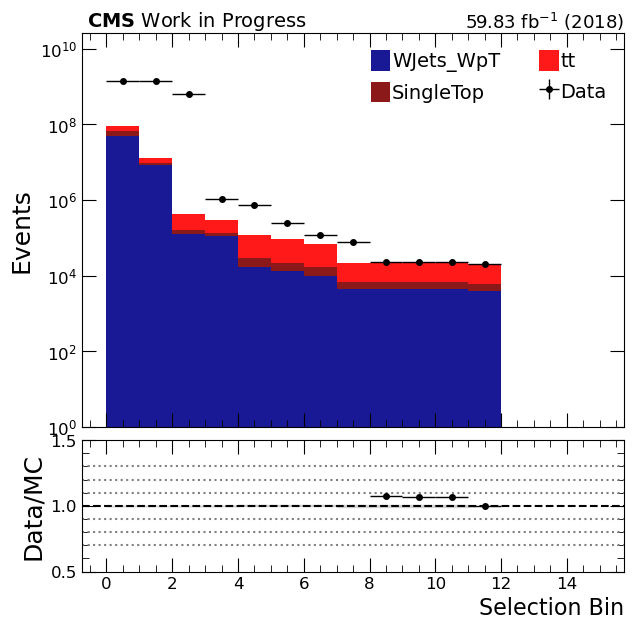

In [19]:
# make cutflow plot
hMC = outputHistMC[key]
hData = outputHistData[key][{'dataset':sum}]
plotWithRatio(h=hMC, hData=hData, overlay='dataset', logY=True, xLabel='Selection Bin', xRange=None, colors_cat='Topmu', extraText=None, lumi=59.83, year=2018)

In [20]:
import os.path
from coffea import util
from coffea.btag_tools import BTagScaleFactor
from coffea.jetmet_tools import CorrectedJetsFactory, JECStack
from coffea.lookup_tools import extractor
import pickle


In [21]:
#Electron Reconstruction SF
cwd = 'monoHbb/efficiencies'
ex = extractor()
ex.add_weight_sets([f"ElectronrecoSF EGamma_SF2D {cwd}/egammaEffi_ptAbove20_UL2018.root"])
ex.finalize()
evaluator = ex.make_evaluator()
ElectronrecoEffLookup_18 = evaluator['ElectronrecoSF']
ElectronrecoEffLookup_18

2 dimensional histogram with axes:
	1: [-2.5   -2.    -1.566 -1.444 -1.    -0.5    0.     0.5    1.     1.444
  1.566  2.     2.5  ]
	2: [ 20.  45.  75. 100. 500.]

In [22]:
selections = ak.Array([True,True,False,True,True,False,True,True])
selections

<Array [True, True, False, ... True, True] type='8 * bool'>

In [23]:
weights = ak.Array([1.01,0.98,0.97,1.03,1.02,0.97,0.99,0.95])
weights

<Array [1.01, 0.98, 0.97, ... 0.97, 0.99, 0.95] type='8 * float64'>

In [24]:
 weights[selections]

<Array [1.01, 0.98, 1.03, 1.02, 0.99, 0.95] type='6 * float64'>

In [26]:
 ak.sum(weights[selections])

5.98

In [27]:
from coffea.analysis_tools import PackedSelection, Weights

In [28]:
weights_CR = Weights(len(events))
weights_CR.add("NoWeight", weight=np.ones(len(events)))

In [32]:
def get_electron_weight(tight_electrons, lookup_table):
    '''
    Provides the electron trigger or reco scale factor in appropriate event weight format.
    '''
    a =  ak.mask(tight_electrons, ak.num(tight_electrons) == 1)
    b = lookup_table(abs(a.eta),a.pt)
    c = ak.fill_none(b,[-1] , axis = 0)
    d = ak.flatten(c)
    e = ak.mask(d, d>0)
    return e

ElectronrecoSFWeight = get_electron_weight(events.Electron,ElectronrecoEffLookup_18)

ElectronrecoSF_err = ak.where(ElectronrecoSFWeight>0, 0.01, 0.00) # assigning 1 % uncertainty to all


ElectronrecoSFWeight_Up = (ElectronrecoSFWeight + ElectronrecoSF_err)
ElectronrecoSFWeight_Down = (ElectronrecoSFWeight - ElectronrecoSF_err)
 
weights_CR.add("ElectronrecoSFWeight",weight=ElectronrecoSFWeight,weightUp=ElectronrecoSFWeight_Up,weightDown=ElectronrecoSFWeight_Down,)      

In [37]:
weights_CR.weight()

array([1.        , 0.987526  , 1.        , ..., 0.98770493, 1.        ,
       1.        ])